In [1]:
import cv2
import numpy as np
import math
import bisect
from google.colab.patches import cv2_imshow
from skimage import morphology
from sklearn.cluster import KMeans

def imadjust(src, tol=1, vin=[0,255], vout=(0,255)):
    # src : input one-layer image (numpy array)
    # tol : tolerance, from 0 to 100.
    # vin  : src image bounds
    # vout : dst image bounds
    # return : output img

    dst = src.copy()
    tol = max(0, min(100, tol))

    if tol > 0:
        # Compute in and out limits
        # Histogram
        hist = np.zeros(256, dtype=np.int)
        for r in range(src.shape[0]):
            for c in range(src.shape[1]):
                hist[src[r,c]] += 1
        # Cumulative histogram
        cum = hist.copy()
        for i in range(1, len(hist)):
            cum[i] = cum[i - 1] + hist[i]

        # Compute bounds
        total = src.shape[0] * src.shape[1]
        low_bound = total * tol / 100
        upp_bound = total * (100 - tol) / 100
        vin[0] = bisect.bisect_left(cum, low_bound)
        vin[1] = bisect.bisect_left(cum, upp_bound)

    # Stretching
    scale = (vout[1] - vout[0]) / (vin[1] - vin[0])
    for r in range(dst.shape[0]):
        for c in range(dst.shape[1]):
            vs = max(src[r,c] - vin[0], 0)
            vd = min(int(vs * scale + 0.5) + vout[0], vout[1])
            dst[r,c] = vd
    return dst

def matlab_fspecial(typex = "motion", len = 9, theta = 0):
  # h = fspecial('motion',len,theta)
  if typex == 'motion':
    # Create the vertical kernel. 
    kernel_v = np.zeros((len, theta)) 

    # Fill the middle row with ones. 
    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size) 

    # Normalize. 
    kernel_v /= kernel_size 

    # Apply the vertical kernel. 
    motion_blur = cv2.filter2D(img, -1, kernel_v) 
    return motion_blur

# equal to mat2gray on matlab 
# https://stackoverflow.com/questions/39808545/implement-mat2gray-in-opencv-with-python
def matlab_mat2gray(A, alpha = False, beta = False):
  if not alpha:
    alpha = min(A.flatten())
  else:
    alpha = 0
    
  if not beta:
    beta = max(A.flatten())
  else:
    beta = 255

  I = A
  cv2.normalize(A, I, alpha , beta ,cv2.NORM_MINMAX)
  I = np.uint8(I)
  return I

def matlab_strel_disk(r1):
  from skimage.morphology import disk

  mask = disk(r1)
  return mask

def matlab_strel_ball(r1,r2):
  from skimage.morphology import (octagon)

  mask = octagon(r1,r2)
  return mask

In [2]:
# function to resize image 
def resize_img(file, size = 200):
  nrows = (np.shape(file)[0])  # image height 
  ncols = (np.shape(file)[1]) 
  ratio = nrows/ncols
  t_width = size
  t_height = math.ceil(t_width * ratio)
  return cv2.resize(file, (t_width, t_height))

# get filename from path
def getfilename(path, ext = False):
  import ntpath
  import os
  if ext:
    return ntpath.basename(path)
  else:
    return os.path.splitext(ntpath.basename(path))[0]


In [3]:
# original script of vogado's segmentation method
# clustering using k-means
def wbc_vogado(f, debug_mode = False):
  image_lab = int(0)
  image_rgb = f  # send into figure (a)]

  # time measurement 
  import time
  start_time = time.time()

  # pre-processing step, convert rgb into CIELAB (L*a*b)
  image_lab = cv2.cvtColor(image_rgb, cv2.COLOR_BGR2Lab);
  L = image_lab[:,:,0]
  A = image_lab[:,:,1]
  B = image_lab[:,:,2] # the bcomponent
  lab_y = B # send into figure (c)

  AD = cv2.add(L,B)

  # f (bgr)
  r = f[:,:,2] # red channel (rgb)
  r = imadjust(r)
  g = f[:,:,1]
  g = imadjust(g)
  b = f[:,:,0]
  b = imadjust(b)
  c = np.subtract(255,r)
  c = imadjust(c)
  m = np.subtract(255,g)

  cmyk_m = m # send into figure (b)
  m = cv2.blur(m,(10,10)) # updated in 13/04/2016 - 6:15
  cmyk_m_con_med  = m # send into figure (d)
  m = imadjust(m)
  y = np.subtract(255,b)
  y = imadjust(y)
  AD = matlab_mat2gray(B)
  AD = cv2.medianBlur(AD,7)
  lab_y_con_med = AD # send into figure (e)

  # subtract the M and b
  sub = cv2.subtract(m,AD)
  img_subt = sub #  send into figure (f)
  CMY = np.stack((c,m,y), axis=2) 
  F = np.stack((r, g, b), axis=2)
  ab = CMY # generate CMY color model
  nrows = (np.shape(f)[0])  # image height 
  ncols = (np.shape(f)[1]) 

  # reshape into one single array
  ab = ab.flatten()
  x = nrows
  y = ncols
  data = sub.flatten() # sub = result of subtraction M and b, put them into one long array

  ## step 2 - clustering
  nColors = 3  # Number of clusters (k)
  kmeans = KMeans(n_clusters=nColors, random_state=0)
  kmeans.fit_predict(data.reshape(-1, 1))
  # cluster_idx, cluster_center =  kmeans.cluster_centers_
  cluster_idx = kmeans.labels_ # index result of kmeans
  cluster_center = kmeans.cluster_centers_ #  position of cluster center
  pixel_labels = np.reshape(cluster_idx, (nrows, ncols));
  pixel_labels = np.uint8(pixel_labels)
 
  # the problem is here, 
  tmp =  np.sort(cluster_center.flatten())
  idx = np.zeros((len(tmp), 1))
  for i in range(len(tmp)):
    idx[i] = cluster_center.tolist().index(tmp[i])

  nuclei_cluster = idx[2] # sort asc, nuclei cluster is always who has higher value
  A = np.zeros((nrows, ncols), dtype=np.uint8)

  # print(np.shape(A))
  for row in range(nrows):
    for col in range(ncols):
      # print(" pixel_labels[row,col] = ",  row, col)
      if pixel_labels[row,col] == nuclei_cluster:
        A[row,col] = 255
      else:
        A[row,col] = 0

  ## step 3 - post-processing
  img_clustering = A # send into figure (x)
  img_clustering = imadjust(img_clustering)

  sed = matlab_strel_disk(7) # disk
  see = matlab_strel_ball(3,3) #circle 

  A = cv2.dilate(A,sed)
  # erosion
  A = cv2.erode(A, see)  
  # remove area < 800px 
  A = morphology.area_opening(A, area_threshold=800*3, connectivity=1) # vogado mention he use 800px
  img_morpho = A # send into figure (g)

  # debug mode 
  if(debug_mode):
    # resize image into width 200px 
    ratio = ncols/nrows
    t_width = 200
    t_height = math.ceil(t_width * ratio)
    print("(a) Original")
    cv2_imshow(resize_img(image_rgb, t_width))
    print("(b) M from CMYK")
    cv2_imshow(resize_img(cmyk_m, t_width))
    print("(c) *b from CIELAB")
    cv2_imshow(resize_img(lab_y, t_width))
    print("(d) M con adj + med(7x7)")
    cv2_imshow(resize_img(cmyk_m_con_med, t_width))
    print("(e) *b con adj + med(7x7)")
    cv2_imshow(resize_img(lab_y_con_med, t_width))
    print("(f) *b - M")
    cv2_imshow(resize_img(img_subt, t_width))
    print("(x) clustering" )
    cv2_imshow(resize_img(img_clustering, t_width))
    print("(g)  Morphological Ops.")
    cv2_imshow(resize_img(img_morpho, t_width))
  print("--- %s seconds ---" % (time.time() - start_time))
  return img_morpho

(a) Original


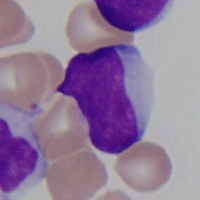

(b) M from CMYK


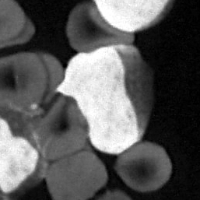

(c) *b from CIELAB


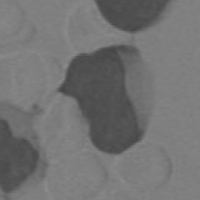

(d) M con adj + med(7x7)


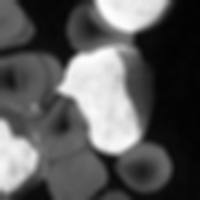

(e) *b con adj + med(7x7)


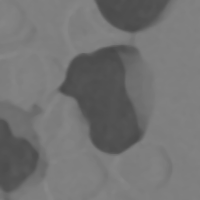

(f) *b - M


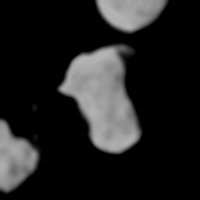

(x) clustering


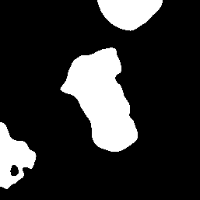

(g)  Morphological Ops.


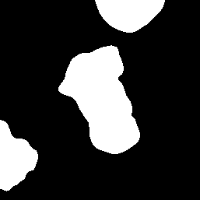

--- 4.469851493835449 seconds ---


In [4]:
path = "drive/My Drive/ALL_IDB2/Im007_1.jpg"
original_image = cv2.imread(path)
result = wbc_vogado(original_image, True) 